In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surabhik12","key":"f7a9be65a8db646ab2177a0c49b85c9c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Check if kaggle is working
!kaggle datasets list | head

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           8028        173  1.0              
jockeroika/life-style-data                                    Life Style Data                                       6289184  2025-10-13 02:11:38.793000           2607         66  0.9411765        
grandmaster07/student-exam-score-dataset-analysis             Student exam score dataset analysis                      2430  2025-09-26 07:44:12.677000           3346         73  1.0              
anassarfraz13/c

In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d /content/HAM10000

Streaming output truncated to the last 5000 lines.
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029337.jpg  


In [5]:
import os, shutil, glob

combined_path = '/content/HAM10000/images'
os.makedirs(combined_path, exist_ok=True)

for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    for f in glob.glob(f'/content/HAM10000/{folder}/*.*'):
        shutil.copy(f, combined_path)

print("Total original images:", len(glob.glob(os.path.join(combined_path, '*.*'))))

Total original images: 10015


In [6]:
from PIL import Image, ImageOps, ImageEnhance
import random

target_count = 20000
imgs = glob.glob(os.path.join(combined_path, '*.*'))
i = 0

while len(glob.glob(os.path.join(combined_path, '*.*'))) < target_count:
    src = random.choice(imgs)
    im = Image.open(src).convert('RGB')

    if random.random() < 0.5:
        im = ImageOps.mirror(im)
    if random.random() < 0.5:
        im = im.rotate(random.choice([90, 180, 270]))
    if random.random() < 0.5:
        enhancer = ImageEnhance.Color(im)
        im = enhancer.enhance(0.8 + random.random()*0.8)

    out_path = os.path.join(combined_path, f'aug_{i:06d}.jpg')
    im.save(out_path)
    i += 1

print("Total images after augmentation:", len(glob.glob(os.path.join(combined_path, '*.*'))))

Total images after augmentation: 20000


In [9]:
import os
import pandas as pd
import glob

# Path to your merged image folder
image_dir = '/content/HAM10000/images'

# Get all image file paths
image_paths = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))

# Create a dataframe (if you don’t have labels, we can fill them later)
df = pd.DataFrame({'image_path': image_paths})

# Optional: add a dummy label column if needed for dataloader compatibility
df['label'] = 'unknown'

# Save the metadata CSV
csv_path = '/content/HAM10000_augmented_metadata.csv'
df.to_csv(csv_path, index=False)

print(f"Metadata CSV saved: {csv_path}")
print("Total images listed:", len(df))

Metadata CSV saved: /content/HAM10000_augmented_metadata.csv
Total images listed: 20000


In [12]:
# ============================================================
# Load full 20K augmented HAM10000 dataset for GAN
# ============================================================
import os, glob
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader

# Path to your combined 20K folder
image_dir = '/content/HAM10000/images'

# Create dataframe (no split, all images)
image_paths = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
df = pd.DataFrame({'image_path': image_paths})
df['label'] = 'unknown'  # dummy label

# GAN transform
gan_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset + dataloader
gan_dataset = HAM10000Dataset(df, transform=gan_transform)
dataloader = DataLoader(gan_dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"Loaded {len(df)} images for GAN training")

Loaded 20000 images for GAN training


In [14]:
import glob, os
len(glob.glob('/content/HAM10000/images/*.*'))

20000

In [18]:
# ============================================================
# STEP 3 — TRAIN DCGAN TO GENERATE SYNTHETIC IMAGES
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# 1️⃣ Custom Dataset class for HAM10000
# ============================================================
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label for GAN

# ============================================================
# 2️⃣ Transformations for GAN
# ============================================================
gan_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ============================================================
# 3️⃣ Load dataset for GAN training (use only training set)
# ============================================================
import glob

# Build dataframe
import pandas as pd
train_df = pd.DataFrame({"image_path": image_paths})

# Create dataset + dataloader
gan_dataset = HAM10000Dataset(train_df, transform=gan_transform)
dataloader = DataLoader(gan_dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"✅ Loaded {len(gan_dataset)} images for GAN training")

# ============================================================
# 4️⃣ Define Generator and Discriminator (DCGAN)
# ============================================================
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        out = self.main(x)
        # Average spatial dimensions to get a single scalar per image
        out = torch.sigmoid(out.mean(dim=[1, 2, 3]))
        return out


# ============================================================
# 5️⃣ Initialize Networks, Loss, and Optimizers
# ============================================================
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 100
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# ============================================================
# 6️⃣ Train DCGAN
# ============================================================
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        b_size = real_imgs.size(0)
        real_label = torch.full((b_size,), 1., device=device)
        fake_label = torch.full((b_size,), 0., device=device)

        # ---- Train Discriminator ----
        netD.zero_grad()
        output_real = netD(real_imgs)
        lossD_real = criterion(output_real, real_label)

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake_imgs = netG(noise)
        output_fake = netD(fake_imgs.detach())
        lossD_fake = criterion(output_fake, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()
        output = netD(fake_imgs)
        lossG = criterion(output, real_label)
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {lossD:.4f} | Loss_G: {lossG:.4f}")

    if (epoch+1) % 5 == 0:
        fake_sample = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake_sample, f"fake_samples_epoch_{epoch+1}.png", normalize=True)

print("✅ GAN training complete!")

# ============================================================
# 7️⃣ Generate & Save New Synthetic Images (e.g., 5000)
# ============================================================
output_dir = "synthetic_images"
os.makedirs(output_dir, exist_ok=True)

netG.eval()
num_new_images = 5000
batch_size = 64
saved = 0

print("🧩 Generating 5000 synthetic images...")
with torch.no_grad():
    for _ in tqdm(range(num_new_images // batch_size)):
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_imgs = netG(noise).detach().cpu()
        for j in range(fake_imgs.size(0)):
            vutils.save_image(fake_imgs[j], os.path.join(output_dir, f"synthetic_{saved+j}.png"), normalize=True)
        saved += fake_imgs.size(0)

print(f"✅ Saved {saved} synthetic images to '{output_dir}' folder.")

Using device: cuda
✅ Loaded 20000 images for GAN training
Epoch [1/100] | Loss_D: 0.3153 | Loss_G: 3.0084
Epoch [2/100] | Loss_D: 0.4292 | Loss_G: 3.0005
Epoch [3/100] | Loss_D: 0.2947 | Loss_G: 2.3911
Epoch [4/100] | Loss_D: 0.5550 | Loss_G: 2.2817
Epoch [5/100] | Loss_D: 0.9774 | Loss_G: 4.0343
Epoch [6/100] | Loss_D: 0.3252 | Loss_G: 2.9338
Epoch [7/100] | Loss_D: 0.4767 | Loss_G: 3.0572
Epoch [8/100] | Loss_D: 1.0126 | Loss_G: 4.4350
Epoch [9/100] | Loss_D: 0.3317 | Loss_G: 2.7999
Epoch [10/100] | Loss_D: 0.2562 | Loss_G: 3.0757
Epoch [11/100] | Loss_D: 0.7052 | Loss_G: 3.8464
Epoch [12/100] | Loss_D: 0.5517 | Loss_G: 1.1209
Epoch [13/100] | Loss_D: 0.2100 | Loss_G: 2.8797
Epoch [14/100] | Loss_D: 0.7082 | Loss_G: 2.1882
Epoch [15/100] | Loss_D: 0.4221 | Loss_G: 3.5660
Epoch [16/100] | Loss_D: 0.3399 | Loss_G: 2.4932
Epoch [17/100] | Loss_D: 1.3943 | Loss_G: 3.5564
Epoch [18/100] | Loss_D: 3.7053 | Loss_G: 1.2612
Epoch [19/100] | Loss_D: 0.0246 | Loss_G: 6.9291
Epoch [20/100] | Los

100%|██████████| 78/78 [00:07<00:00,  9.98it/s]

✅ Saved 4992 synthetic images to 'synthetic_images' folder.


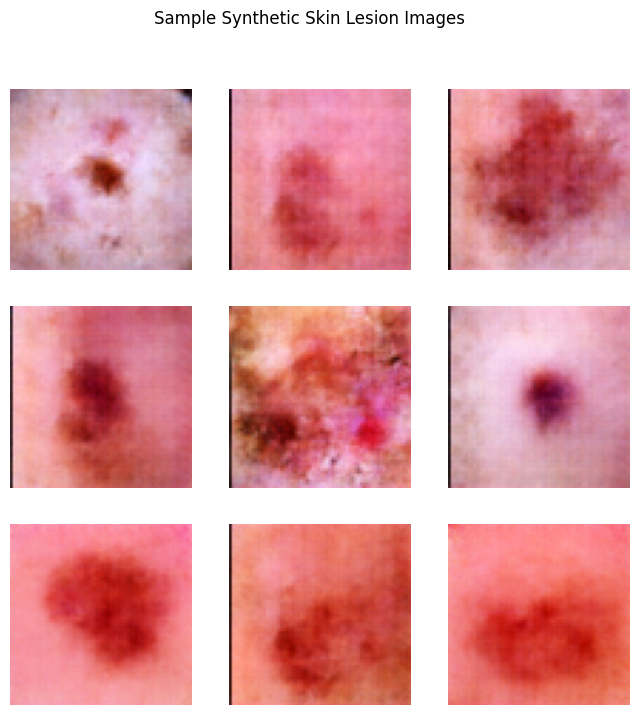

In [19]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random

synthetic_samples = random.sample(glob.glob("synthetic_images/*.png"), 9)
plt.figure(figsize=(8,8))
for i, path in enumerate(synthetic_samples):
    img = Image.open(path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Sample Synthetic Skin Lesion Images")
plt.show()


In [27]:
!pip uninstall -y torchmetrics torch-fidelity

Found existing installation: torchmetrics 1.8.2
Uninstalling torchmetrics-1.8.2:
  Successfully uninstalled torchmetrics-1.8.2
Found existing installation: torch-fidelity 0.3.0
Uninstalling torch-fidelity-0.3.0:
  Successfully uninstalled torch-fidelity-0.3.0


In [28]:
!pip install "torchmetrics[image]" --upgrade

  Using cached torchmetrics-1.8.2-py3-none-any.whl.metadata (22 kB)
  Using cached torch_fidelity-0.3.0-py3-none-any.whl.metadata (2.0 kB)
Using cached torch_fidelity-0.3.0-py3-none-any.whl (37 kB)
Using cached torchmetrics-1.8.2-py3-none-any.whl (983 kB)


In [29]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [31]:
!pip install torch-fidelity --upgrade

from torch_fidelity import calculate_metrics

real_path = '/content/HAM10000/images'
gen_path = '/content/synthetic_images'

metrics = calculate_metrics(
    input1=real_path,
    input2=gen_path,
    cuda=True if torch.cuda.is_available() else False,
    isc=False,  # Set False if you don't need Inception Score
    fid=True,
    kid=False,
    verbose=True
)

print("FID Score:", metrics['frechet_inception_distance'])

Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 138MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/HAM10000/images" with extensions png,jpg,jpeg
Found 20000 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/pyth

FID Score: 154.53060779391083


Frechet Inception Distance: 154.53060779391083


In [33]:
!pip install piq

import piq
from PIL import Image
import os
import torch
from torchvision import transforms

gen_path = '/content/synthetic_images'
real_path = '/content/HAM10000/images'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

ssim_scores = []
gen_images = sorted([f for f in os.listdir(gen_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
real_images = sorted([f for f in os.listdir(real_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])[:len(gen_images)]

for g, r in zip(gen_images, real_images):
    gen_img = transform(Image.open(os.path.join(gen_path, g)).convert('RGB')).unsqueeze(0)
    real_img = transform(Image.open(os.path.join(real_path, r)).convert('RGB')).unsqueeze(0)
    score = piq.ssim(gen_img, real_img, data_range=1.0)
    ssim_scores.append(score.item())

print("Average SSIM:", sum(ssim_scores)/len(ssim_scores))

Average SSIM: 0.6433240078980677


In [37]:
import lpips
from PIL import Image
import torch
from torchvision import transforms
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = lpips.LPIPS(net='alex').to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # gives [0,1]
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)  # [1,3,H,W]
    img = img * 2 - 1  # scale to [-1,1]
    return img

gen_path = '/content/synthetic_images'
real_path = '/content/HAM10000/images'

lpips_scores = []
gen_images = sorted([f for f in os.listdir(gen_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
real_images = sorted([f for f in os.listdir(real_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])[:len(gen_images)]

for g, r in zip(gen_images, real_images):
    gen_img = load_image(os.path.join(gen_path, g))
    real_img = load_image(os.path.join(real_path, r))
    score = loss_fn(gen_img, real_img)
    lpips_scores.append(score.item())

print("Average LPIPS:", sum(lpips_scores)/len(lpips_scores))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Average LPIPS: 0.6158428317031417


In [35]:
!pip install pytorch-fid torch torchvision

import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from scipy.stats import entropy
from torchvision.models import inception_v3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Inception v3
model = inception_v3(pretrained=True, transform_input=False).to(device)
model.eval()

def get_pred(img):
    with torch.no_grad():
        img = img.to(device)
        pred = model(img)
        pred = torch.nn.functional.softmax(pred, dim=1)
    return pred.cpu().numpy()

# Transform
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

gen_path = '/content/synthetic_images'
gen_images = sorted([f for f in os.listdir(gen_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])

preds = []
for g in gen_images:
    img = transform(Image.open(os.path.join(gen_path, g)).convert('RGB')).unsqueeze(0)
    pred = get_pred(img)
    preds.append(pred[0])

preds = np.array(preds)

# Inception Score calculation
def inception_score(preds, splits=10):
    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for k in range(splits):
        part = preds[k*split_size:(k+1)*split_size, :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(p, py) for p in part])))
    return np.mean(scores), np.std(scores)

mean_IS, std_IS = inception_score(preds)
print("Inception Score:", mean_IS, "±", std_IS)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 155MB/s] 


Inception Score: 2.7417798 ± 0.051810544


In [38]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Folder to save results
save_path = '/content/drive/MyDrive/Diffusion_Model_Results'
os.makedirs(save_path, exist_ok=True)

Mounted at /content/drive


In [61]:
# =====================================
# SAVE METRICS & GENERATED IMAGES TO DRIVE
# =====================================
import os, json, shutil
import torch

# Set up save directory
MODEL_NAME = "GAN_Diffusion"  # Change to your model name
save_dir = f"/content/drive/MyDrive/AI_Comparisons/{MODEL_NAME}_Results"
os.makedirs(save_dir, exist_ok=True)

# Save generated images
gen_folder = "synthetic_images"  # GAN/Diffusion generated images folder
if os.path.exists(gen_folder):
    shutil.copytree(gen_folder, os.path.join(save_dir, 'generated_images'), dirs_exist_ok=True)
    print(f" Generated images saved to: {os.path.join(save_dir, 'generated_images')}")

 Generated images saved to: /content/drive/MyDrive/AI_Comparisons/GAN_Diffusion_Results/generated_images


In [60]:
# =====================================
# POST-HOC GAN METRICS COMPUTATION & SAVE
# =====================================
import os, json, shutil
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from torch_fidelity import calculate_metrics
import piq
import lpips
from torchvision.models import inception_v3
from scipy.stats import entropy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

real_path = '/content/HAM10000/images'
gen_path = 'synthetic_images'

# -------------------
# FID
# -------------------
fid_metrics = calculate_metrics(
    input1=real_path,
    input2=gen_path,
    cuda=torch.cuda.is_available(),
    isc=False, fid=True, kid=False
)
# Use the correct key to access the FID score
fid_score = float(fid_metrics['frechet_inception_distance'])

# -------------------
# SSIM
# -------------------
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
gen_images = sorted([f for f in os.listdir(gen_path) if f.lower().endswith(('.png','.jpg'))])
real_images = sorted([f for f in os.listdir(real_path) if f.lower().endswith(('.png','.jpg'))])[:len(gen_images)]

ssim_scores = []
for g, r in zip(gen_images, real_images):
    gen_img = transform(Image.open(os.path.join(gen_path, g)).convert('RGB')).unsqueeze(0)
    real_img = transform(Image.open(os.path.join(real_path, r)).convert('RGB')).unsqueeze(0)
    ssim_scores.append(piq.ssim(gen_img, real_img, data_range=1.0).item())
ssim_score = float(np.mean(ssim_scores))

# -------------------
# LPIPS
# -------------------
loss_fn = lpips.LPIPS(net='alex').to(device)
def load_img(path):
    img = transform(Image.open(path).convert('RGB')).unsqueeze(0).to(device)
    img = img*2-1
    return img

lpips_scores = []
for g, r in zip(gen_images, real_images):
    lpips_scores.append(loss_fn(load_img(os.path.join(gen_path, g)), load_img(os.path.join(real_path, r))).item())
lpips_score = float(np.mean(lpips_scores))

# -------------------
# Inception Score
# -------------------
model = inception_v3(pretrained=True, transform_input=False).to(device)
model.eval()

def get_pred(img):
    with torch.no_grad():
        pred = model(img.to(device))
        pred = torch.nn.functional.softmax(pred, dim=1)
    return pred.cpu().numpy()

preds = []
for g in gen_images:
    img = transform(Image.open(os.path.join(gen_path, g)).convert('RGB')).unsqueeze(0)
    preds.append(get_pred(img)[0])
preds = np.array(preds)

def inception_score(preds, splits=10):
    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for k in range(splits):
        part = preds[k*split_size:(k+1)*split_size, :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(p, py) for p in part])))
    return np.mean(scores), np.std(scores)

mean_IS, std_IS = inception_score(preds)
inception_score_val = float(mean_IS)

# -------------------
# Save results to Drive
# -------------------
save_dir = "/content/drive/MyDrive/AI_Comparisons/GAN_Results"
os.makedirs(save_dir, exist_ok=True)

metrics_to_save = {
    "FID": fid_score,
    "SSIM": ssim_score,
    "LPIPS": lpips_score,
    "Inception_Score": inception_score_val,
    "num_images": len(gen_images)
}

# Save JSON
json_file = os.path.join(save_dir, "gan_metrics.json")
with open(json_file, "w") as f:
    json.dump(metrics_to_save, f, indent=4)

# Copy generated images
shutil.copytree(gen_path, os.path.join(save_dir, 'generated_images'), dirs_exist_ok=True)

print(f"✅ Metrics & images saved to: {save_dir}")
print(metrics_to_save)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/HAM10000/images" with extensions png,jpg,jpeg
Found 20000 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "synthetic_images" with extensions png,jpg,jpeg
Found 4992 samples
Processing samples
Frechet Inception Distance: 154.53060779391083


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Metrics & images saved to: /content/drive/MyDrive/AI_Comparisons/GAN_Results
{'FID': 154.53060779391083, 'SSIM': 0.6433240078980677, 'LPIPS': 0.6158428317031417, 'Inception_Score': 3.466585159301758, 'num_images': 4992}
